# 1. Problem Statement

This project aims to predict the likelihood of diabetes in individuals based on various health-related factors. The dataset includes features such as age, gender, BMI, blood pressure, glucose levels, family history, and lifestyle habits. The goal is to develop a predictive model that can accurately identify individuals at risk of developing diabetes, thereby supporting early diagnosis and prevention efforts.

# 2. Data Exploration

## 2.1. Importing data and required libraries. Initial exploration

In [5]:
# Basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from xgboost import XGBClassifier

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

# Model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, roc_auc_score, recall_score

# Optimization and Model saving
import optuna
import joblib

# Utility and system related
import json
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Read the files
df = pd.read_csv(r'C:\Users\arailym\Projects\Diabetes-Prediction-using-by-XGBoost-ML\Dataset\diabetes_train.csv', index_col=0) 

# Exploring the combined dataset
exploring = {
    'Shape': df.shape,
    'Columns': df.columns.to_list(),
    'Head': df.head(5),
    'Info': df.info(),
    'Description': df.describe(),
    'Distinct Values': df.nunique(),
    'Missing Values': df.isnull().sum(),
}

# Print all exploration results
for key, value in exploring.items():
    print(f"\n{'-'*50}\n{key}:")
    print(value)

<class 'pandas.core.frame.DataFrame'>
Index: 73718 entries, 0 to 73717
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   73718 non-null  object 
 1   gender               73718 non-null  object 
 2   age                  73718 non-null  float64
 3   hypertension         73718 non-null  int64  
 4   heart_disease        73718 non-null  int64  
 5   smoking_history      73718 non-null  object 
 6   bmi                  73718 non-null  float64
 7   HbA1c_level          73718 non-null  float64
 8   blood_glucose_level  73718 non-null  int64  
 9   diabetes             73718 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 6.2+ MB

--------------------------------------------------
Shape:
(73718, 10)

--------------------------------------------------
Columns:
['ID', 'gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blo

Dataset information
- **ID**: A unique identifier assigned to each individual in the dataset, used for distinguishing records.
- **Gender**: Indicates the gender of the individual (e.g., male or female), which may have implications for the likelihood of developing diabetes.
- **Age**: Represents the age of the individual, as age is a significant factor in assessing diabetes risk.
- **Hypertension**: A binary indicator showing whether the individual has high blood pressure, which is a common comorbidity linked to diabetes.
- **Heart Disease**: A binary indicator of whether the individual has been diagnosed with heart disease, often correlated with an increased risk of diabetes.
- **Smoking History**: Categorical data indicating the individual’s smoking habits (e.g., non-smoker, current smoker, former smoker), as smoking can affect overall health and diabetes risk.
- **BMI**: Body Mass Index, a numerical value calculated from height and weight, used to assess if an individual is underweight, healthy, overweight, or obese, impacting the risk of diabetes.
- **HbA1c Level**: Represents the average blood sugar level over the past 2-3 months, a key indicator for assessing diabetes risk or control.
- **Blood Glucose Level**: A measurement of the individual’s current blood glucose concentration, critical for detecting diabetes or hyperglycemia.
- **Diabetes**: A target variable indicating whether the individual has diabetes, typically binary (e.g., 'Yes' or 'No'), which is the outcome the model aims to predict.

Comments:
- no missing values in the dataset.
- no duplicates in the dataset. Delete ID column, which is not affect to training model.
- total 9 features in dataset. 
- out of total 9 features there are 5 Categorical Features.
- out of total 9 features there are 4 Numerical Features.

## 2.2. Data preparation

In [6]:
# Drop ID, data_source columns
df = df.drop(columns=['ID'], errors='ignore')
df_copy = df.copy()

In [7]:
# Define column lists
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_cols = ['gender', 'hypertension', 'heart_disease']
ordinal_cols = ['smoking_history']
target_col = 'diabetes' 

# Create a copy of the dataframe for encoding
encoded_df = df_copy.copy()

# Label encode binary columns
label_encoders = {}
for col in binary_cols:
    label_encoders[col] = LabelEncoder()
    encoded_df[col] = label_encoders[col].fit_transform(df_copy[col])
    print(f"\n{col} encoding mapping:")
    print(dict(zip(label_encoders[col].classes_, 
                   label_encoders[col].transform(label_encoders[col].classes_))))

# Ordinal encode smoking_history
smoking_order = ['never', 'former', 'not current', 'ever', 'current', 'No Info']
ordinal_encoder = OrdinalEncoder(categories=[smoking_order])
encoded_df[ordinal_cols] = ordinal_encoder.fit_transform(df_copy[ordinal_cols])

print("\nSmoking history ordinal mapping:")
for i, category in enumerate(smoking_order):
    print(f"{category}: {i}")

# Scale numerical features
scaler = MinMaxScaler()
encoded_df[numerical_cols] = scaler.fit_transform(df_copy[numerical_cols])

# Path to existing artifact directory
BASE_PATH = '../artifact'  # Assuming notebooks are in 'notebook' directory
scalers_encoders_dir = os.path.join(BASE_PATH, 'scalers_and_encoders')
os.makedirs(scalers_encoders_dir, exist_ok=True)

# Get timestamp for versioning
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Save label encoders
for col in binary_cols:
    encoder_path = os.path.join(scalers_encoders_dir, f'label_encoder_{col}_{timestamp}.joblib')
    joblib.dump(label_encoders[col], encoder_path)
    print(f"Saved label encoder for {col} to: {encoder_path}")

# Save ordinal encoder
ordinal_path = os.path.join(scalers_encoders_dir, f'ordinal_encoder_{timestamp}.joblib')
joblib.dump(ordinal_encoder, ordinal_path)
print(f"Saved ordinal encoder to: {ordinal_path}")

# Save scaler
scaler_path = os.path.join(scalers_encoders_dir, f'scaler_{timestamp}.joblib')
joblib.dump(scaler, scaler_path)
print(f"Saved scaler to: {scaler_path}")

# Save feature information
feature_info = {
    'numerical_cols': numerical_cols,
    'binary_cols': binary_cols,
    'ordinal_cols': ordinal_cols,
    'target_col': target_col,
    'smoking_order': smoking_order
}
info_path = os.path.join(scalers_encoders_dir, f'feature_info_{timestamp}.json')
with open(info_path, 'w') as f:
    json.dump(feature_info, f, indent=4)
print(f"Saved feature information to: {info_path}")


gender encoding mapping:
{'Female': 0, 'Male': 1, 'Other': 2}

hypertension encoding mapping:
{0: 0, 1: 1}

heart_disease encoding mapping:
{0: 0, 1: 1}

Smoking history ordinal mapping:
never: 0
former: 1
not current: 2
ever: 3
current: 4
No Info: 5
Saved label encoder for gender to: ../artifact\scalers_and_encoders\label_encoder_gender_20241130_152639.joblib
Saved label encoder for hypertension to: ../artifact\scalers_and_encoders\label_encoder_hypertension_20241130_152639.joblib
Saved label encoder for heart_disease to: ../artifact\scalers_and_encoders\label_encoder_heart_disease_20241130_152639.joblib
Saved ordinal encoder to: ../artifact\scalers_and_encoders\ordinal_encoder_20241130_152639.joblib
Saved scaler to: ../artifact\scalers_and_encoders\scaler_20241130_152639.joblib
Saved feature information to: ../artifact\scalers_and_encoders\feature_info_20241130_152639.json


Comment - 

- For the 'smoking_history' column, ordinal encoding was applied, assigning values based on increasing relative risk levels (from low, which is 'never' to high 'current').
- The 'gender', 'hypertension', and 'heart_disease' columns were encoded using label encoding to transform categorical values into numerical representations.
- All numerical features were scaled using MinMaxScaler to normalize their values between 0 and 1.
- The fitted encoders and scalers have been saved in the 'encoders' directory to ensure consistent preprocessing for future test datasets."

## 2.3. Exploratory data analysis

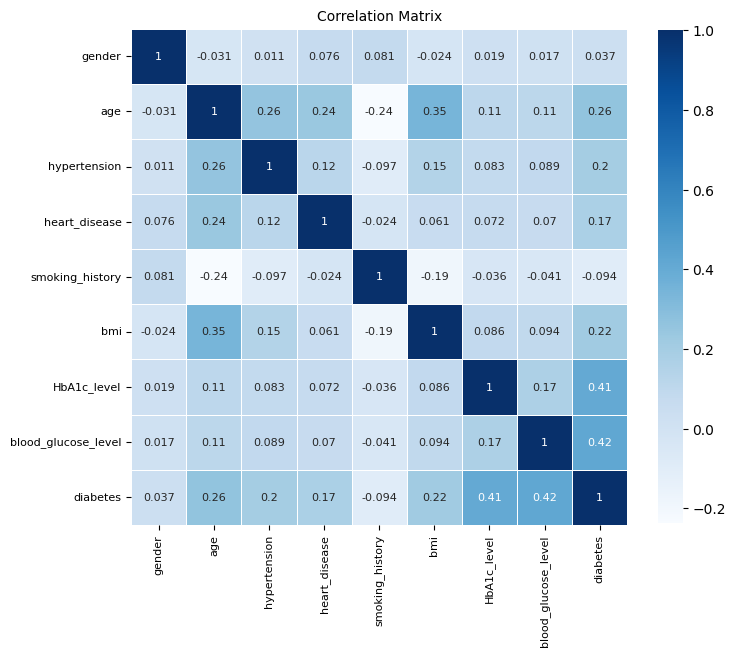

In [8]:
plt.figure(figsize=(8,8))
sns.heatmap(encoded_df.corr(), annot=True, square=True, linewidths=.5, cmap='Blues', cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
plt.title('Correlation Matrix', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Insight:
- High blood glucose levels and elevated HbA1c levels show a strong correlation with the presence of diabetes.
- Age, BMI, hypertension, and heart disease exhibit a moderate correlation with diabetes.

<Figure size 700x700 with 0 Axes>

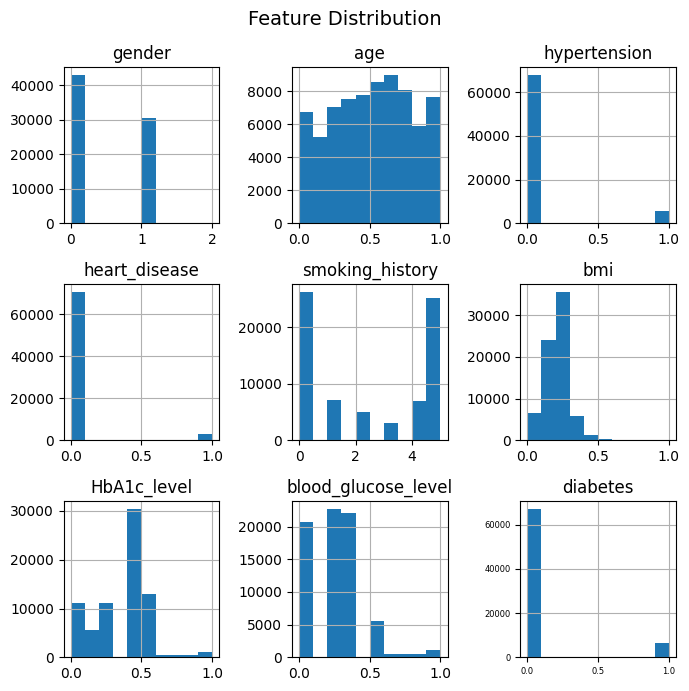

In [9]:
# Check distribution
plt.figure(figsize=(7,7))
encoded_df.hist(figsize=(7,7))
plt.suptitle('Feature Distribution', fontsize=14)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

Insight - 
- Distribution plots show significant imbalances across various health conditions, such as hypertension, heart disease, and diabetes, with most values skewed towards healthier outcomes. 
- Age and BMI are more uniformly distributed, while smoking history and HbA1c/blood glucose levels show varied but also skewed patterns, suggesting the need for careful handling of these disparities during model training.

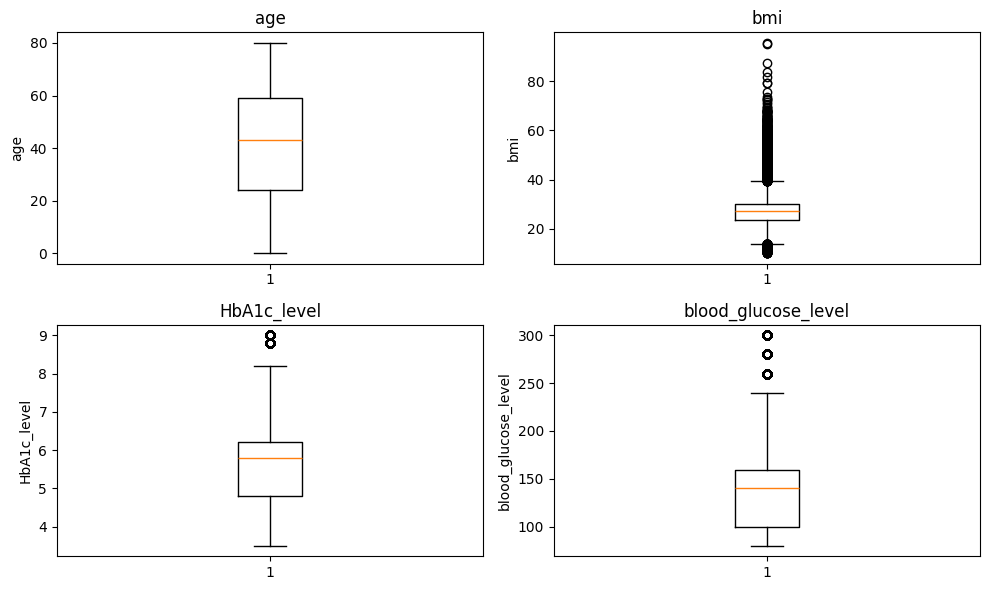

In [10]:
attributes = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Flatten axes array to make indexing easier
axes = axes.ravel()

# Create boxplots for each numerical attribute
for i, attr in enumerate(attributes):

    axes[i].boxplot(df_copy[attr])
    axes[i].set_title(attr)
    axes[i].set_ylabel(attr)  # Use the attribute name as y-axis label

plt.tight_layout()
plt.show()

Insight - 
- The age and HbA1c level distributions are fairly symmetrical, indicating a balanced spread of data across different age groups and HbA1c levels with no extreme outliers.
- BMI level show significant high-value outliers, which may require handling through transformation or removal to ensure robust model performance.

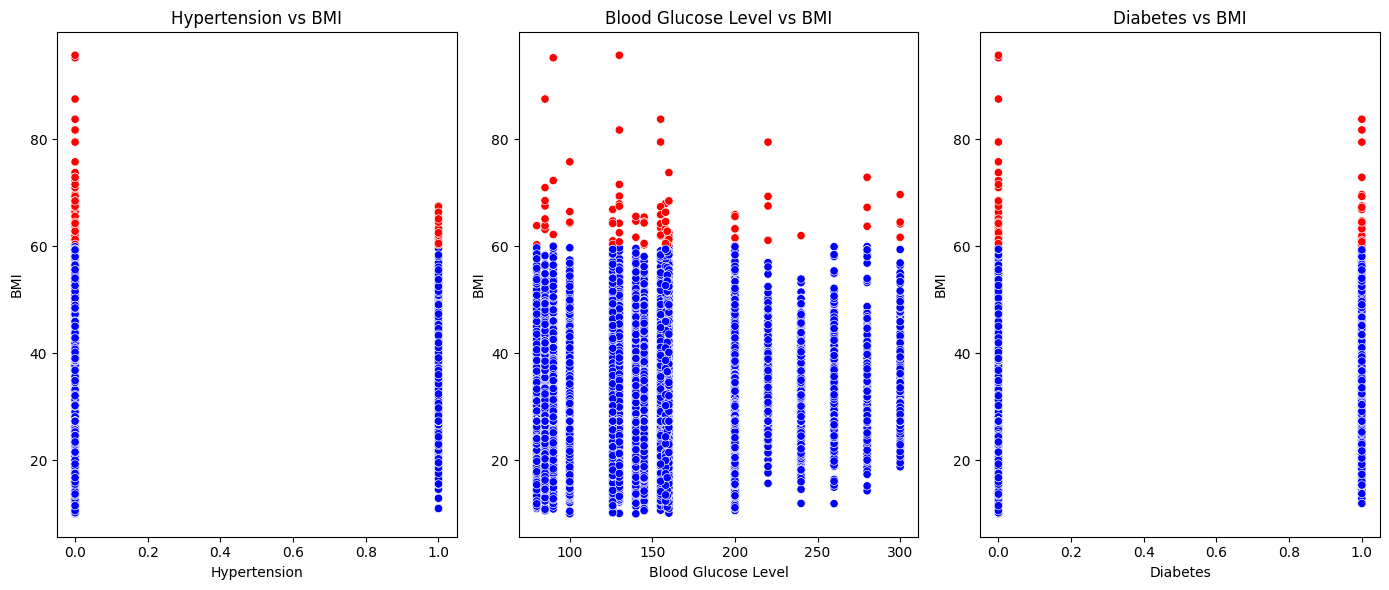

In [11]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Scatter plot 1: Hypertension vs BMI
sns.scatterplot(data=df_copy, x='hypertension', y='bmi', ax=axes[0], 
                hue=df_copy['bmi'] > 60, palette={True: 'red', False: 'blue'}, 
                legend=False)
axes[0].set_title('Hypertension vs BMI')
axes[0].set_xlabel('Hypertension')
axes[0].set_ylabel('BMI')

# Scatter plot 2: Blood Glucose Level vs BMI
sns.scatterplot(data=df_copy, x='blood_glucose_level', y='bmi', ax=axes[1], 
                hue=df_copy['bmi'] > 60, palette={True: 'red', False: 'blue'}, 
                legend=False)
axes[1].set_title('Blood Glucose Level vs BMI')
axes[1].set_xlabel('Blood Glucose Level')
axes[1].set_ylabel('BMI')

# Scatter plot 3: Diabetes vs BMI
sns.scatterplot(data=df_copy, x='diabetes', y='bmi', ax=axes[2], 
                hue=df_copy['bmi'] > 60, palette={True: 'red', False: 'blue'}, 
                legend=False)
axes[2].set_title('Diabetes vs BMI')
axes[2].set_xlabel('Diabetes')
axes[2].set_ylabel('BMI')

plt.tight_layout()
plt.show()

Insights:

- There are unusually high BMI values (> 60) for individuals without hypertension or diabetes, which are not typically observed in real populations according to World Health Organization standards.
- BMI values above 60 are disproportionately common, especially for lower blood glucose levels, and should be treated as outliers, which need to remove.


BMI Outlier Analysis:
Lower Bound: 0.14
Upper Bound: 0.59
Original Size: 73718
Size after Removing Outliers: 59164
Number of Outliers Removed: 14554
Removed Outliers Percentage: 19.74%


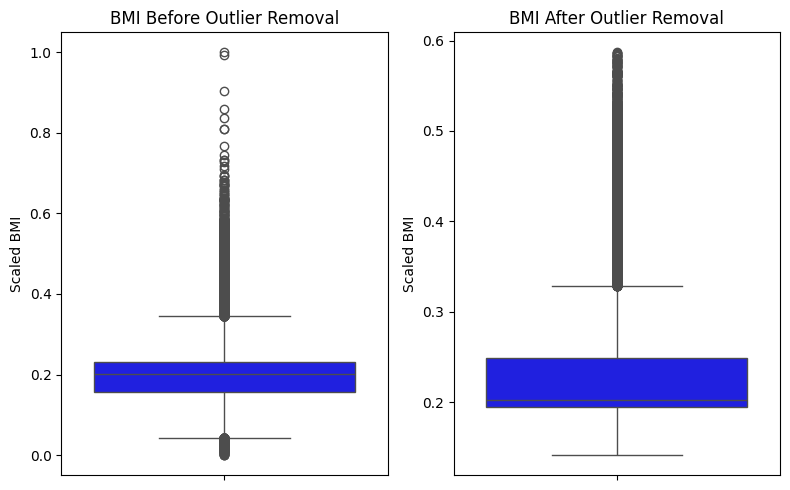

In [12]:
# Now remove BMI outliers after scaling
Q1 = encoded_df['bmi'].quantile(0.25)
Q3 = encoded_df['bmi'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 0.2 * IQR
upper_bound = Q3 + 4.7 * IQR

# Store original data for visualization
original_bmi = encoded_df['bmi'].copy()

# Remove BMI outliers
bmi_mask = (encoded_df['bmi'] >= lower_bound) & (encoded_df['bmi'] <= upper_bound)
encoded_df = encoded_df[bmi_mask].reset_index(drop=True)

# Print BMI outlier analysis
print("\nBMI Outlier Analysis:")
print(f"Lower Bound: {lower_bound:.2f}")
print(f"Upper Bound: {upper_bound:.2f}")
print(f"Original Size: {len(original_bmi)}")
print(f"Size after Removing Outliers: {len(encoded_df)}")
print(f"Number of Outliers Removed: {len(original_bmi) - len(encoded_df)}")
print(f"Removed Outliers Percentage: {((len(original_bmi) - len(encoded_df)) / len(original_bmi) * 100):.2f}%")

# Visualize BMI distribution before and after outlier removal
plt.figure(figsize=(8, 5))

# Before removal
plt.subplot(1, 2, 1)
sns.boxplot(y=original_bmi, color='blue')
plt.title('BMI Before Outlier Removal')
plt.ylabel('Scaled BMI')

# After removal
plt.subplot(1, 2, 2)
sns.boxplot(y=encoded_df['bmi'], color='blue')
plt.title('BMI After Outlier Removal')
plt.ylabel('Scaled BMI')

plt.tight_layout()
plt.show()

# Save the processed data to CSV
encoded_df.to_csv('../Dataset/processed_data.csv', index=False)

Insights:

- Before Outlier Removal: The BMI distribution had a significant number of extreme high values (outliers) that skewed the distribution upwards, as shown by many data points extending far beyond the box.
- After Outlier Removal: The BMI distribution is more compact, with fewer extreme values, resulting in a more balanced and realistic representation. The box plot now shows a cleaner distribution that should improve model accuracy by reducing the influence of outliers.